# Example: Evaluate Segmentation Models on SynthMT

This notebook demonstrates how to:
1. Load the SynthMT dataset from HuggingFace
2. Load a segmentation model using the ModelFactory
3. Run predictions on the dataset (with proper preprocessing)
4. Evaluate performance using segmentation and downstream metrics

## Available Models

The following models are available through the ModelFactory:
- **FIESTA** - Classical filament tracking algorithm (outputs anchor points)
- **SAM, SAM2, SAM3, SAM3Text** - Segment Anything Model variants
- **CellSAM** - Cell-specific SAM variant
- **MicroSAM** - Microscopy-specific SAM (requires conda installation)
- **CellposeSAM** - Cellpose combined with SAM
- **StarDist** - Star-convex polygon detection
- **TARDIS** - Transformer-based detection (outputs anchor points)

In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm import tqdm

from examples.utils import create_overlay
from examples.utils import get_preprocess_params, sample_to_arrays
from synth_mt.benchmark.metrics import calculate_segmentation_metrics, calculate_downstream_metrics
from synth_mt.benchmark.models.anchor_point_model import AnchorPointModel
from synth_mt.benchmark.models.factory import setup_model_factory
from synth_mt.utils import preprocessing as pre


Matlab engine not available
Failed to import micro_sam: No module named 'micro_sam'
Failed to import stardist: No module named 'stardist'


## Load SynthMT Dataset

We load the dataset from HuggingFace and limit to the first 100 images for faster evaluation.


In [2]:
NUM_SAMPLES = 10

ds = load_dataset("HTW-KI-Werkstatt/SynthMT", split="train")
ds = ds.select(range(min(NUM_SAMPLES, len(ds))))

print(f"Loaded {len(ds)} samples for evaluation.")

Loaded 10 samples for evaluation.


## Setup Model Factory and Load Model

The ModelFactory provides a unified interface to load any of the available segmentation models.


In [3]:
factory = setup_model_factory()

print("Available models:")
for model_name in factory.get_available_models():
    print(f"  - {model_name}")

Available models:
  - cellposesam
  - cellsam
  - fiesta
  - microsam
  - sam
  - sam2
  - sam3
  - sam3text
  - stardist
  - tardis


In [4]:
MODEL_NAME = "sam3text"

use_hpo_params = True

if use_hpo_params:
    config_path =  f"../synth_mt/benchmark/models/{MODEL_NAME}_hpo.json"
else:
    config_path =  f"../synth_mt/benchmark/models/{MODEL_NAME}_default.json"

if os.path.exists(config_path):
    with open(config_path, "r") as f:
        model_config_params = json.load(f)
else:
    model_config_params = {}
    print(f"Warning: Config file '{config_path}' not found. Using default parameters.")

model = factory.create_model(MODEL_NAME, **model_config_params)
model.load_model()

print(f"Loaded model: {model}")
print(f"Model type: {'AnchorPointModel' if isinstance(model, AnchorPointModel) else 'MaskModel'}")

print(f"Model configuration from '{config_path}':")
print("Model configuration parameters:")
for key, value in model_config_params.items():
    print(f"  - {key}: {value}")


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loaded model: SAM3Text
Model type: MaskModel
Model configuration from '../synth_mt/benchmark/models/sam3text_hpo.json':
Model configuration parameters:
  - model_name: SAM3Text
  - grayscale: True
  - sharpen_radius: 0.38717865927737405
  - smooth_radius: 3.410555347410367
  - percentile_min: 3.506993161284297
  - percentile_max: 99.46537030219284
  - clip_to_percentiles: True
  - rescale_using_percentiles: True
  - invert: False
  - histogram_normalization: False
  - text_prompt_option: 0
  - threshold: 0.4018846604226014
  - mask_threshold: 0.44189937830348586


# MARKDOWN: Run Predictions

## Run Predictions

Iterate over the dataset and collect predictions and ground truth masks.

**Note:** Some models (FIESTA, TARDIS) output anchor points instead of masks. The metrics functions handle both formats.


In [5]:
preprocess_params = get_preprocess_params(model)

all_gt_masks = []
all_pred_masks = []
all_anchor_points = []
all_images = []

is_anchor_point_model = isinstance(model, AnchorPointModel)

for sample in tqdm(ds, desc=f"Running {MODEL_NAME}"):
    image, gt_masks = sample_to_arrays(sample)
    processed_image = pre.process_image(image, **preprocess_params)
    model_output = model.predict(processed_image)

    if model_output is None:
        print(f"Warning: Model returned None. Skipping.")
        continue

    all_images.append(image)
    all_gt_masks.append(gt_masks)

    if is_anchor_point_model:
        all_anchor_points.append(model_output)
        all_pred_masks.append(None)
    else:
        all_pred_masks.append(model_output)
        all_anchor_points.append(None)

print(f"Completed predictions on {len(all_images)} images.")

Running sam3text: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]

Completed predictions on 10 images.


## Visualize Sample Predictions

Compare ground truth and predicted segmentations on a few examples.

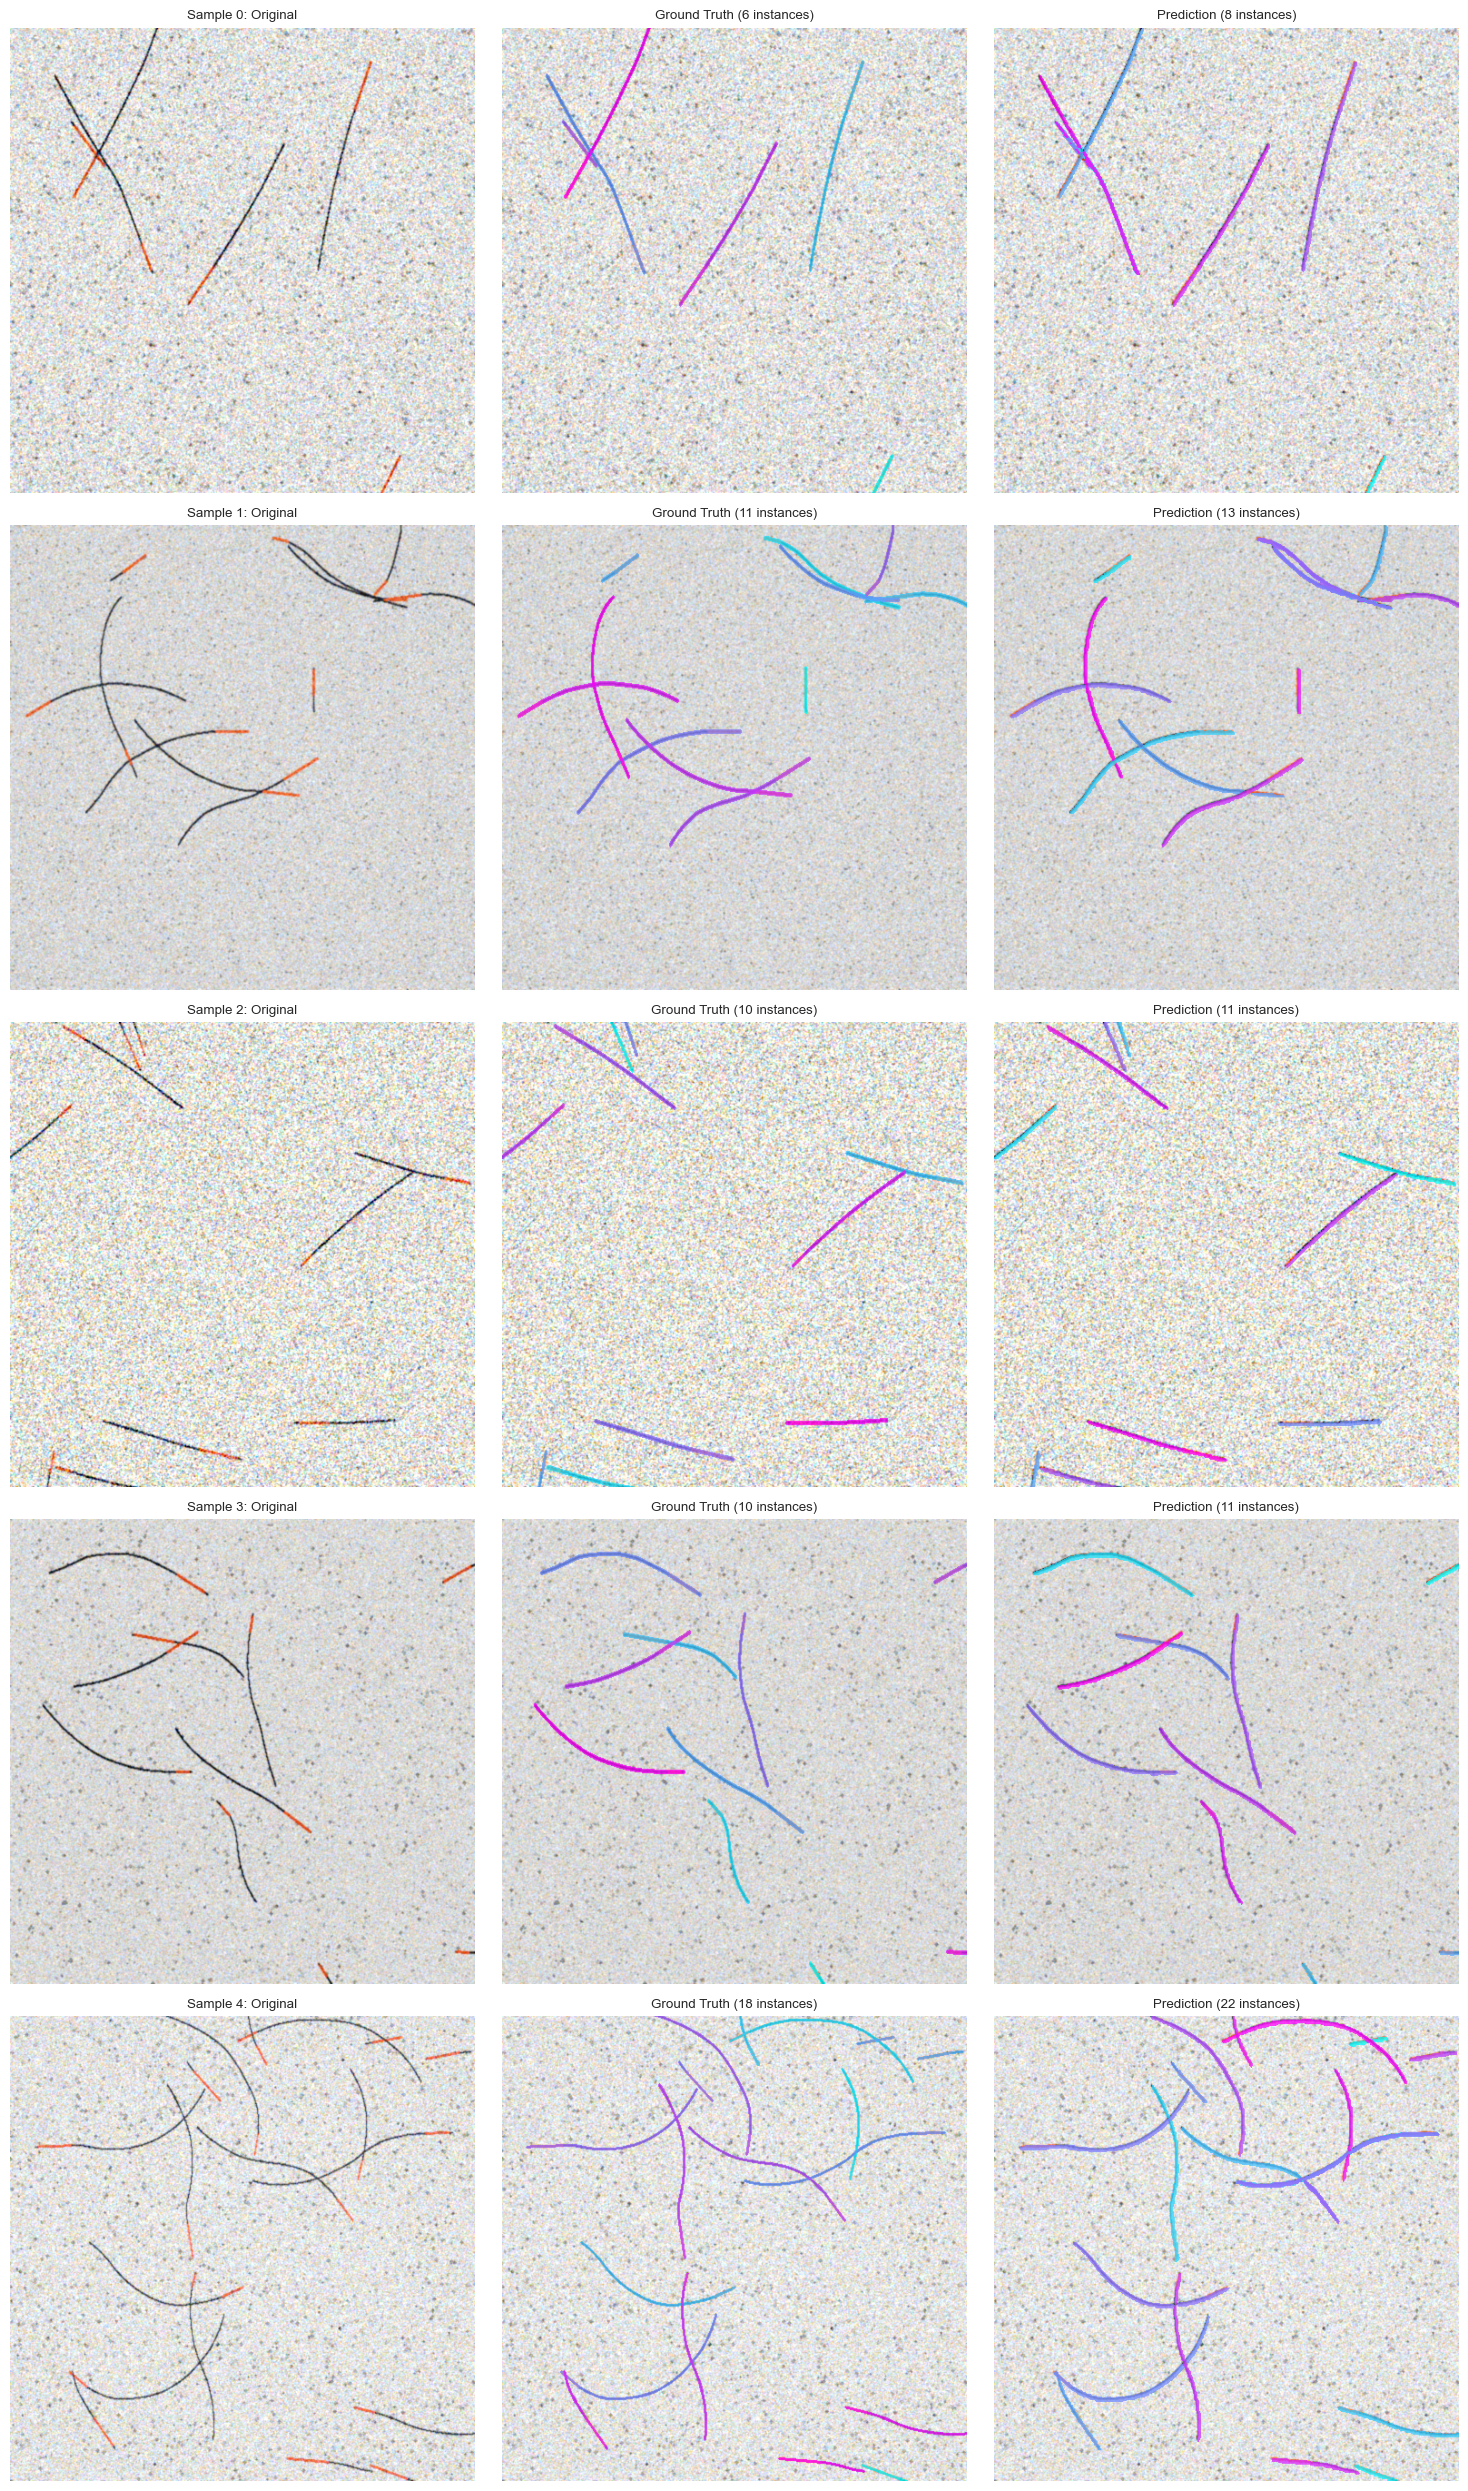

In [6]:
%matplotlib inline

if is_anchor_point_model:
    print("TODO: Implement visualization for anchor point models (FIESTA, TARDIS) in this notebook. Skipping for now..")
else:
    n_samples = min(5, len(all_images))
    fig, axs = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))

    for sample_idx in range(n_samples):
        gt_overlay = create_overlay(all_images[sample_idx], all_gt_masks[sample_idx])
        pred_overlay = create_overlay(all_images[sample_idx], all_pred_masks[sample_idx])

        axs[sample_idx, 0].imshow(all_images[sample_idx])
        axs[sample_idx, 0].set_title(f"Sample {sample_idx}: Original")

        axs[sample_idx, 1].imshow(gt_overlay)
        axs[sample_idx, 1].set_title(f"Ground Truth ({all_gt_masks[sample_idx].shape[0]} instances)")

        axs[sample_idx, 2].imshow(pred_overlay)
        axs[sample_idx, 2].set_title(f"Prediction ({len(np.unique(all_pred_masks[sample_idx]))} instances)")

        axs[sample_idx, 0].axis("off")
        axs[sample_idx, 1].axis("off")
        axs[sample_idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

## Calculate Segmentation Metrics

Compute instance segmentation metrics including:
- **Precision, Recall, F1** at various IoU thresholds
- **Skeletonized IoU (SkIoU)** - IoU computed on skeletonized masks, better suited for filamentous structures
- **Average Precision (AP)** across IoU thresholds

In [7]:
if is_anchor_point_model:
    mean_metrics, std_metrics = calculate_segmentation_metrics(
        gt_masks=all_gt_masks,
        anchor_points_instance_masks=all_anchor_points,
        use_skeletonized_version=True,
    )
else:
    mean_metrics, std_metrics = calculate_segmentation_metrics(
        gt_masks=all_gt_masks,
        pred_masks=all_pred_masks,
        use_skeletonized_version=True,
    )

print(f"\n{'='*60}")
print(f"Segmentation Metrics for {MODEL_NAME}")
print(f"{'='*60}")
print(f"{'Metric':<30} {'Mean':>12}")
print(f"{'-'*60}")
for key in sorted(mean_metrics.keys()):
    print(f"{key:<30} {mean_metrics[key]:>12.4f}")



Segmentation Metrics for sam3text
Metric                                 Mean
------------------------------------------------------------
AP                                   0.9311
AP50-95                              0.9311
AP@0.50                              0.9424
AP@0.75                              0.9341
AP@0.90                              0.8716
F1@0.10                              0.9602
F1@0.20                              0.9602
F1@0.30                              0.9602
F1@0.40                              0.9602
F1@0.50                              0.9602
F1@0.75                              0.9522
F1@0.90                              0.8887
SKIoU_mean                           0.9097
SKIoU_median                         0.9883


## Calculate Downstream Metrics

Compute biologically relevant downstream metrics:
- **Count Error** - Difference in number of detected microtubules
- **Length Distribution** - KL divergence between predicted and ground truth length distributions
- **Curvature Distribution** - KL divergence between predicted and ground truth curvature distributions


In [8]:
if is_anchor_point_model:
    downstream_metrics = calculate_downstream_metrics(
        gt_masks=all_gt_masks,
        anchor_points_instance_masks=all_anchor_points,
        pixel_per_micrometer=9.0,
    )
else:
    downstream_metrics = calculate_downstream_metrics(
        gt_masks=all_gt_masks,
        pred_masks=all_pred_masks,
        pixel_per_micrometer=9.0,
    )

print(f"\n{'='*60}")
print(f"Downstream Metrics for {MODEL_NAME}")
print(f"{'='*60}")
print(f"{'Metric':<40} {'Value':>15}")
print(f"{'-'*60}")
for key, value in downstream_metrics.items():
    if isinstance(value, float):
        print(f"{key:<40} {value:>15.4f}")
    else:
        print(f"{key:<40} {str(value):>15}")


Downstream Metrics for sam3text
Metric                                             Value
------------------------------------------------------------
Length_KL                                         0.0130
Curvature_KL                                      0.0700
Avg Count GT                                     12.4000
Std Count GT                                      4.8000
Avg Count Pred                                   12.9000
Std Count Pred                                    4.9082
Count Abs Err                                     0.5000
Count Rel Err                                     0.0403
Avg Length GT                                   117.2097
Std Length GT                                    57.0494
Avg Length Pred                                 116.8992
Std Length Pred                                  57.3719
Length Avg Abs Err                                0.3105
Avg Curvature GT                                  0.9733
Std Curvature GT                                  0